In [171]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import os

from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [ ]:
# Helper functions / cached data
reports_folder = 'reports'
reports = os.listdir(reports_folder)

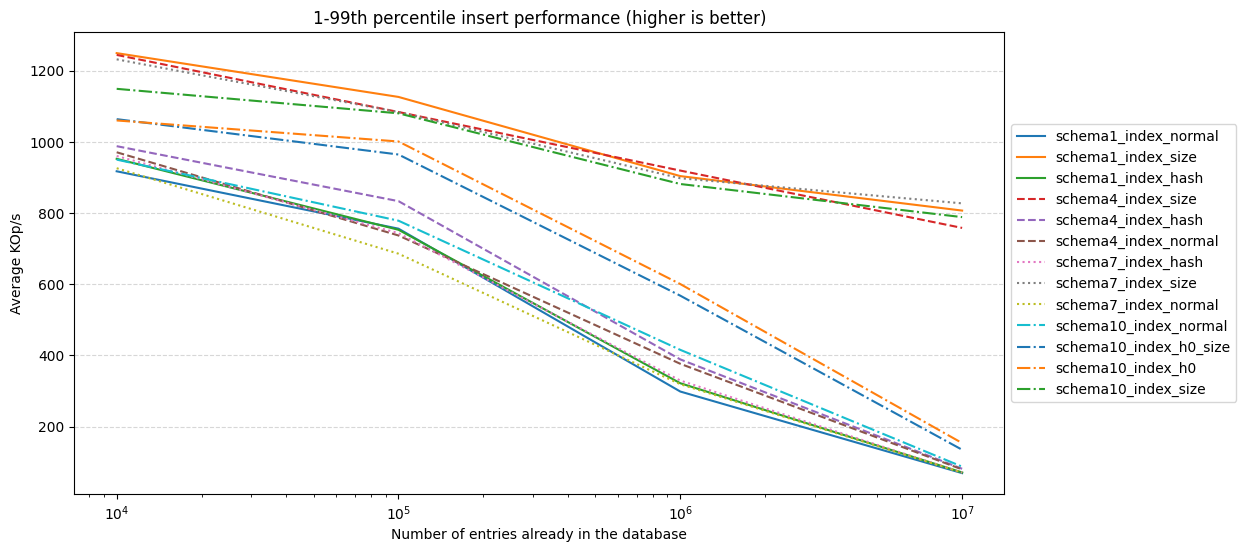

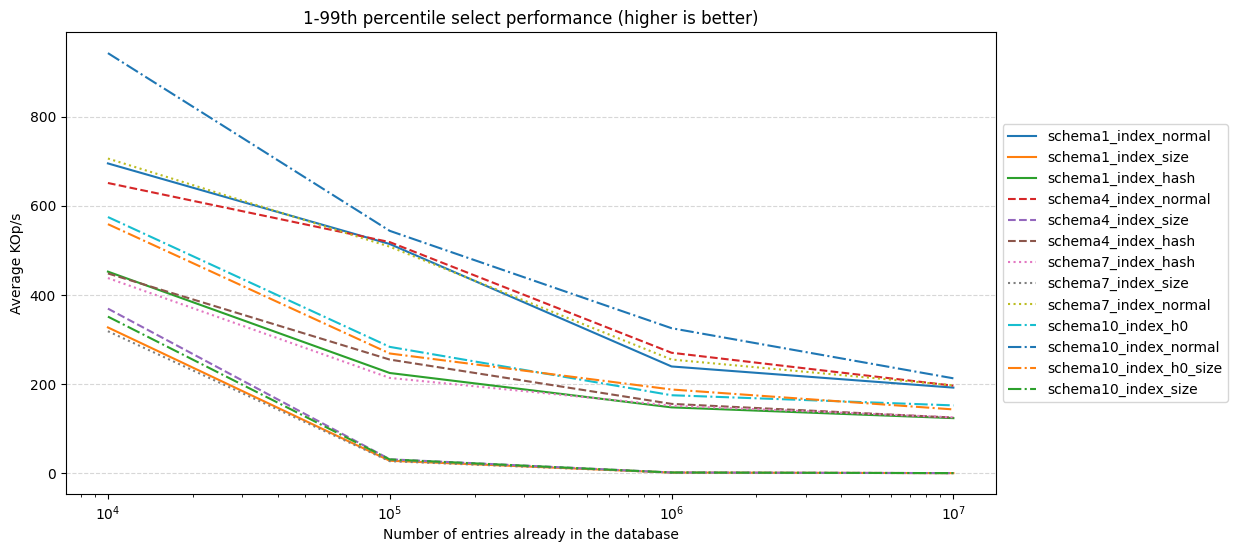

In [ ]:
# Schemas
def read_schemas(filename):
    result = dict()
    sub_benchmarks = ['insert', 'select']
    for sub in sub_benchmarks:
        sub_dict = dict()
        matches = [f for f in reports if f.startswith(f'{filename}_{sub}')]
        for match in matches:
            subsub_dict = dict()
            subsub = match.removeprefix(f'{filename}_{sub}_').removesuffix('.csv')
            with open(f'{reports_folder}/{match}', 'r') as f:
                lines = f.readlines()
            column_names = lines[0].strip().split(',')
            for line in lines[1:]:
                inner = dict()
                values = line.strip().split(',')
                entries = int(values[0])
                for i in range(3, len(column_names)):
                    inner[column_names[i]] = float(values[i])
                subsub_dict[entries] = inner
            sub_dict[subsub] = subsub_dict
        result[sub] = sub_dict
    return result

styles = ['solid', 'dashed', 'dotted', 'dashdot']
def plot_schema(idx, benchmark, style):
    schema = read_schemas(f'schema{idx}')
    for strategy in schema[benchmark]:
        values = [(k, v['1-99_avg_kops']) for k, v in schema[benchmark][strategy].items()]
        x, y = zip(*values)
        plt.plot(x, y, label=f'schema{idx}_{strategy}', linestyle=style)

# Scaling on number of entries in the database prior to running
for b in ['insert', 'select']:
    plt.figure(figsize=(12, 6))
    # Horizontal grid for each y tick
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i, schema in enumerate([1, 4, 7, 10]):
        plot_schema(schema, b, styles[i % len(styles)])

    plt.title(f'1-99th percentile {b} performance (higher is better)')
    plt.xlabel('Number of entries already in the database')
    plt.ylabel('Average KOp/s')
    plt.xscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

Ignoring combination
Ignoring normal


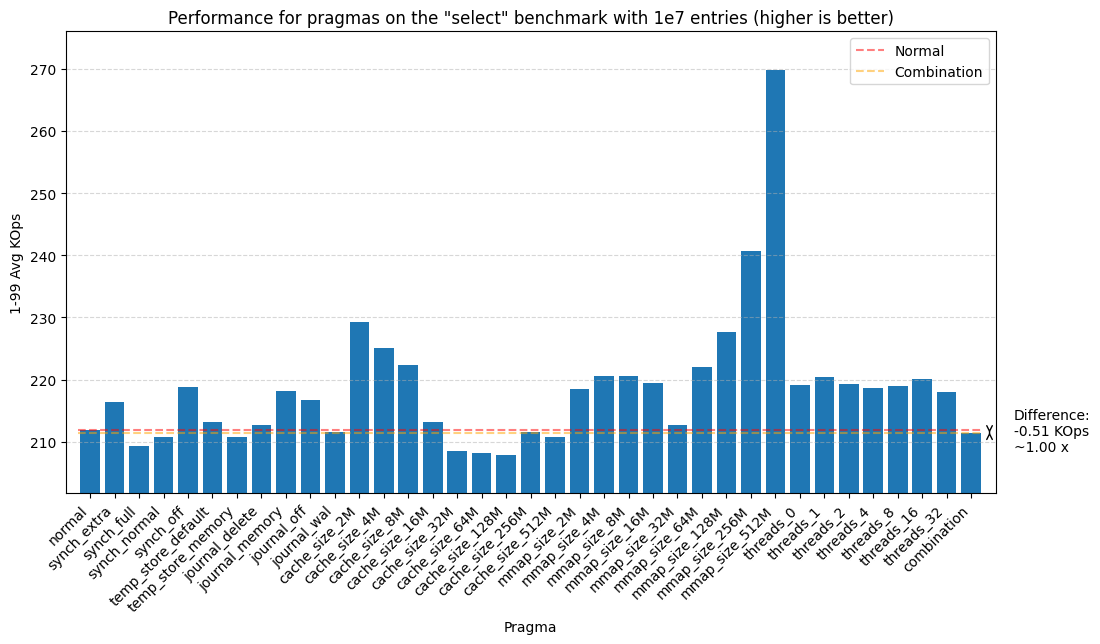

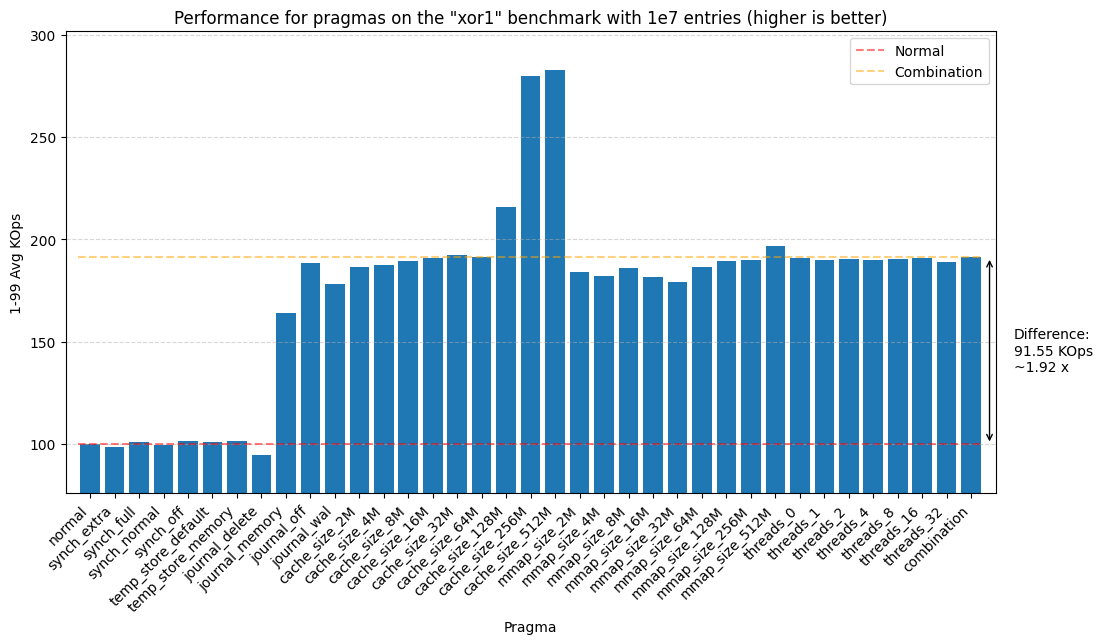

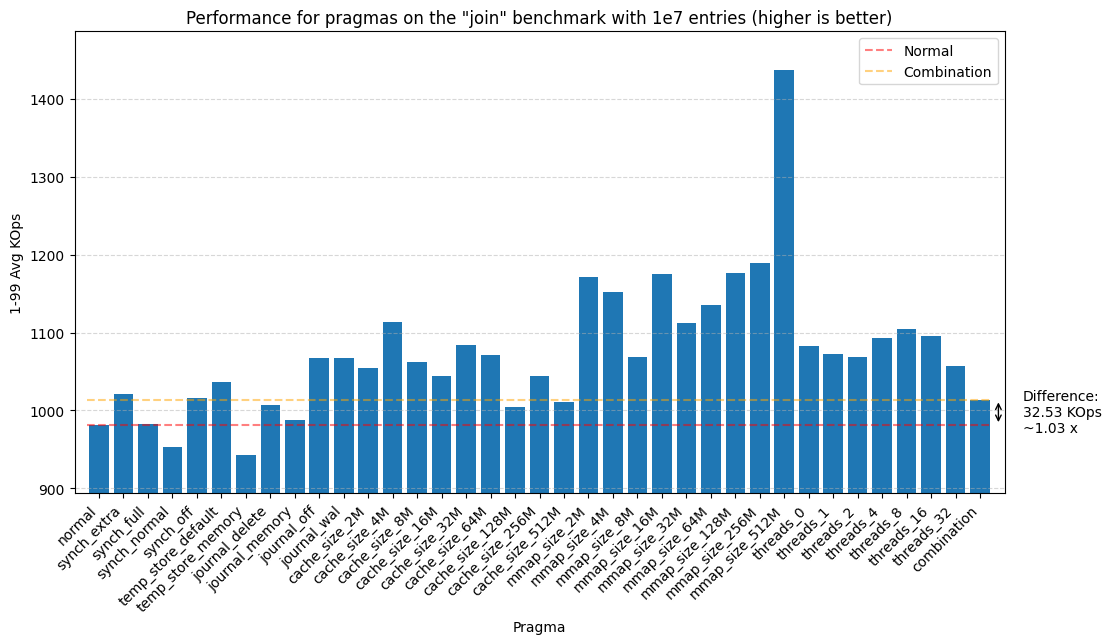

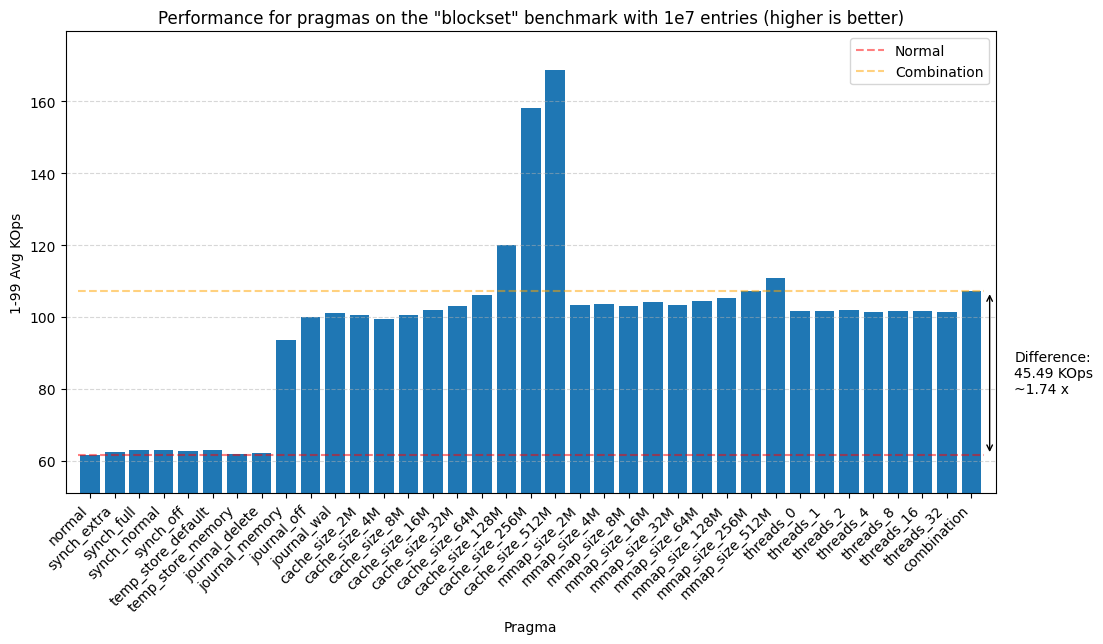

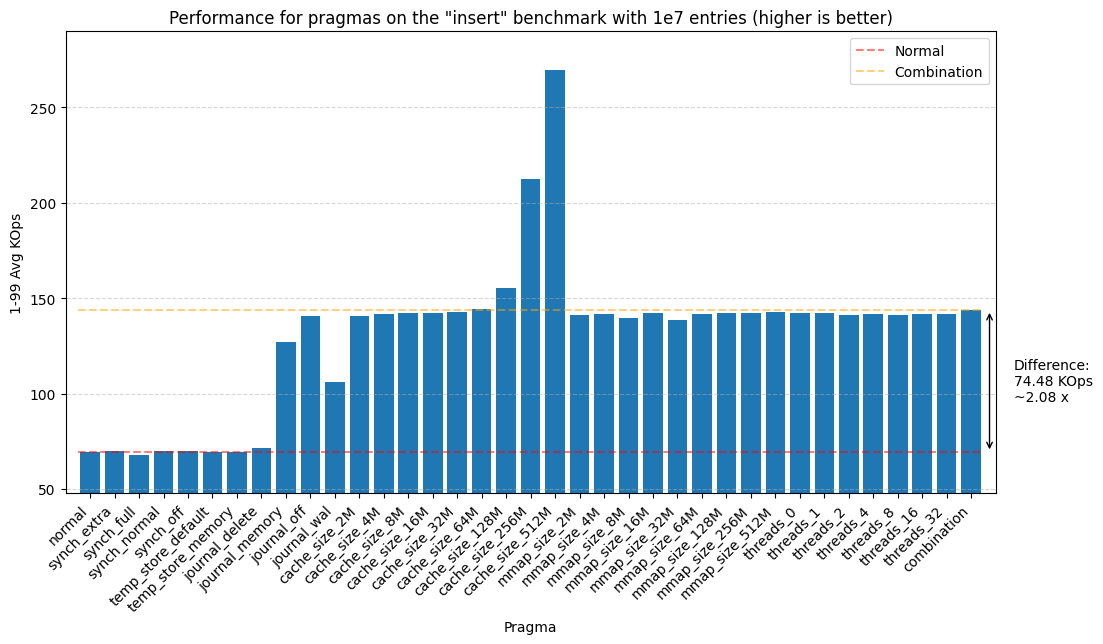

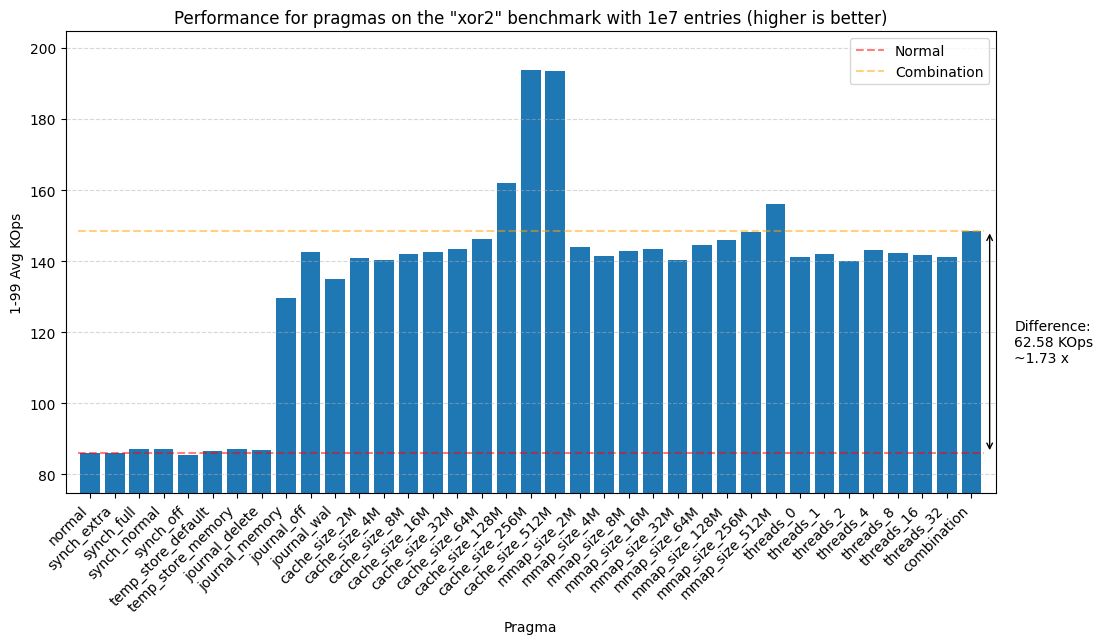

In [ ]:
benchmarks = list(set([(f.split('_'))[1] for f in reports if f.startswith('pragmas')]))
def read_pragmas():
    result = dict()
    for b in benchmarks:
        result[b] = dict()
        matches = [f for f in reports if f.startswith(f'pragmas_{b}_')]
        for match in matches:
            subsub = match.removeprefix(f'pragmas_{b}_').removesuffix('.csv')
            result[b][subsub] = dict()
            with open(f'{reports_folder}/{match}', 'r') as f:
                lines = f.readlines()
            column_names = lines[0].strip().split(',')
            for line in lines[1:]:
                inner = dict()
                values = line.strip().split(',')
                entries = int(values[0])
                for i in range(3, len(column_names)):
                    inner[column_names[i]] = float(values[i])
                result[b][subsub][entries] = inner
    return result

def plot_pragmas_surface(b, sbl, sbs):
    xs = []
    ys = []
    zs = []
    for i, sb in enumerate(sbs):
        for ee in range(4):
            xs.append(ee)
            ys.append(i)
            zs.append(values[b][f'{sbl}_{sb}'][10**(ee+4)]['1-99_avg_kops'])

    xs = np.array(xs)
    ys = np.array(ys)
    zs = np.array(zs)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(20, 10))

    xx, yy = np.meshgrid(np.unique(xs), np.unique(ys))
    xs, ys = xx.ravel(), yy.ravel()
    zs = zs.reshape(xx.shape)
    surf = ax.plot_surface(xx, yy, zs, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    ax.set_xlabel('Number of entries')
    ax.set_ylabel('Pragma value')
    ax.set_zlabel('1-99 Avg KOps')
    ax.set_yticks(np.arange(len(sbs)), labels=sbs)
    ax.set_xticks(xs, labels=[f'1e{(x+4)}' for x in xs])
    plt.title(f'Performance for tuning the {sbl} pragma on the "{b}" benchmark')
    plt.show()

def plot_pragmas_curves(b, sbl, sbs):
    plt.figure(figsize=(12, 6))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    for i, sb in enumerate(sbs):
        xs = []
        ys = []
        zs = []
        for ee in range(4):
            xs.append(10**(ee+4))
            ys.append(i)
            zs.append(values[b][f'{sbl}_{sb}'][10**(ee+4)]['1-99_avg_kops'])

        plt.plot(xs, zs, label=f'{sbl}_{sb}')

    plt.xlabel('Number of entries')
    plt.ylabel('1-99 Avg KOps')
    plt.title(f'Performance for tuning the {sbl} pragma on the "{b}" benchmark')
    plt.xscale('log')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

def plot_pragmas_bar(pragmas, b, e):
    kops = [values[b][p][10**(e+4)]['1-99_avg_kops'] for p in pragmas]
    err_max = 1e6 / np.array([values[b][p][10**(e+4)]['1st'] for p in pragmas])
    err_min = 1e6 / np.array([values[b][p][10**(e+4)]['99th'] for p in pragmas])
    v_normal = kops[0]
    v_combination = kops[-1]

    plt.figure(figsize=(12, 6))
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.hlines([v_normal], xmin=-0.5, xmax=len(pragmas)-0.5, colors=['red'], linestyles='dashed', label='Normal', alpha=.5)
    plt.hlines([v_combination], xmin=-0.5, xmax=len(pragmas)-0.5, colors=['orange'], linestyles='dashed', label='Combination', alpha=.5)

    # If error bars are included, adjust ylim as well
    #plt.bar(pragmas, kops, yerr=[np.array(kops) - np.array(err_min), np.array(err_max) - np.array(kops)])

    plt.bar(pragmas, kops)
    vrange = max(kops) - min(kops)
    diff = v_combination / v_normal
    diff_x = len(pragmas) - .25
    plt.annotate('', xy=(diff_x, v_combination), xytext=(diff_x, v_normal),
                 arrowprops=dict(arrowstyle='<->', color='black'))
    plt.text(diff_x + 1, (v_normal+v_combination)/2, f'Difference:\n{v_combination-v_normal:.2f} KOps\n~{diff:.2f} x', verticalalignment='center', horizontalalignment='left')

    plt.ylim(min(kops) - 0.1 * vrange, max(kops) + 0.1 * vrange)
    plt.xlim(-1, len(pragmas))
    plt.xlabel('Pragma')
    plt.ylabel('1-99 Avg KOps')
    plt.title(f'Performance for pragmas on the "{b}" benchmark with 1e{(e+4)} entries (higher is better)')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.show()

def sort_pragmas():
    pragmas = [f.removeprefix(f'pragmas_{benchmarks[0]}_').removesuffix('.csv') for f in reports if f.startswith(f'pragmas_{benchmarks[0]}_')]
    cache_size = []
    journal = []
    mmap = []
    synch = []
    temp_store = []
    threads = []

    for p in pragmas:
        if p.startswith('cache_size_'):
            cache_size.append(p)
        elif p.startswith('mmap_'):
            mmap.append(p)
        elif p.startswith('threads_'):
            threads.append(p)
        elif p.startswith('synch_'):
            synch.append(p)
        elif p.startswith('temp_store_'):
            temp_store.append(p)
        elif p.startswith('journal_'):
            journal.append(p)
        else:
            print (f'Ignoring {p}')

    cache_size = sorted(cache_size, key=lambda x: int(x.removeprefix('cache_size_').removesuffix('M')))
    journal = sorted(journal)
    mmap = sorted(mmap, key=lambda x: int(x.removeprefix('mmap_size_').removesuffix('M')))
    synch = sorted(synch)
    temp_store = sorted(temp_store)
    threads = sorted(threads, key=lambda x: int(x.removeprefix('threads_')))
    return ['normal'] + synch + temp_store + journal + cache_size + mmap + threads + ['combination']

values = read_pragmas()
pragmas = sort_pragmas()

#b = 'select'
for b in benchmarks:
    #sbl = 'temp_store'
    #sbs = [f.removeprefix(f'pragmas_{b}_{sbl}_').removesuffix('.csv') for f in reports if f.startswith(f'pragmas_{b}_{sbl}')]
    #plot_pragmas_curves(b, sbl, sbs)

    for e in range(3,4):
        try:
            plot_pragmas_bar(pragmas, b, e)
        except:
            pass


['join', 'insert', 'xor1', 'xor2', 'new_blockset', 'select']


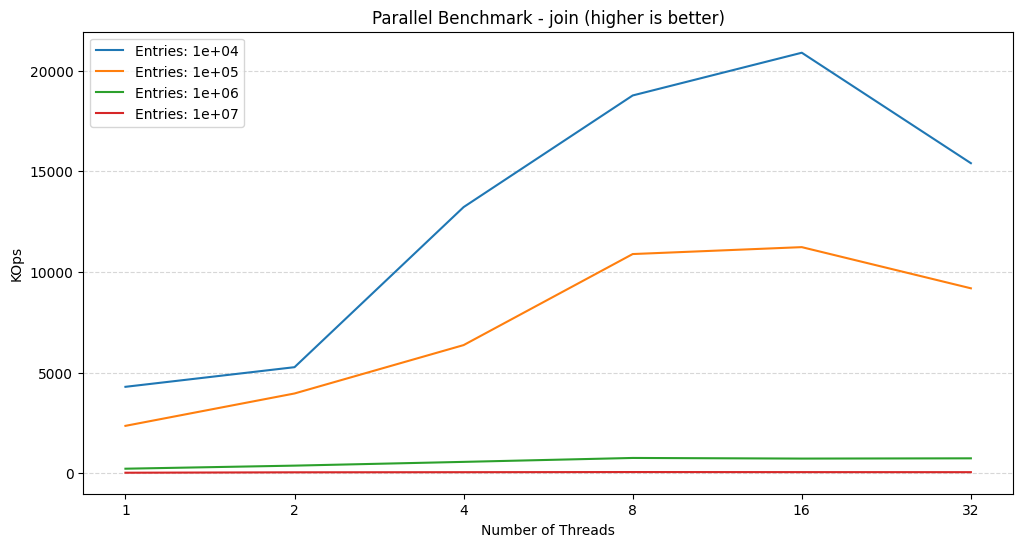

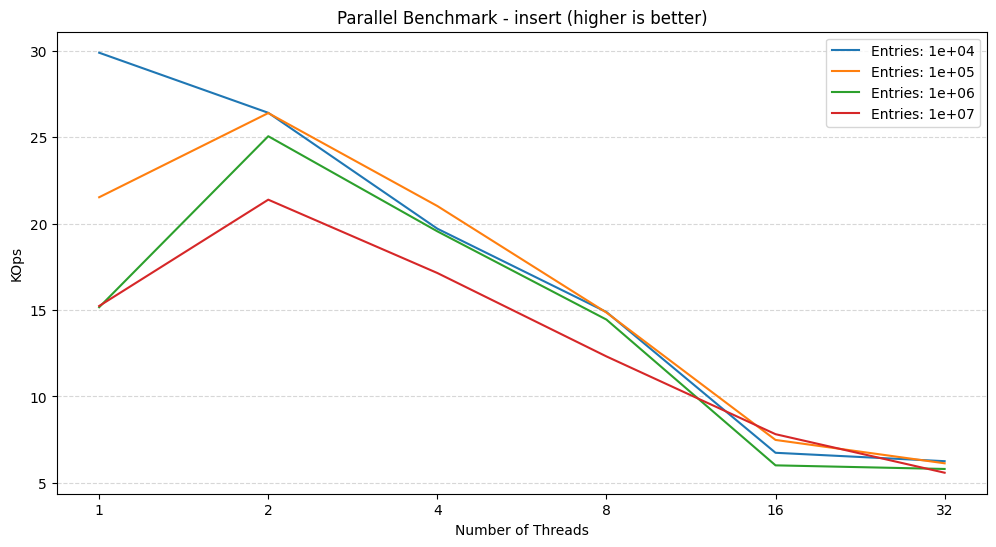

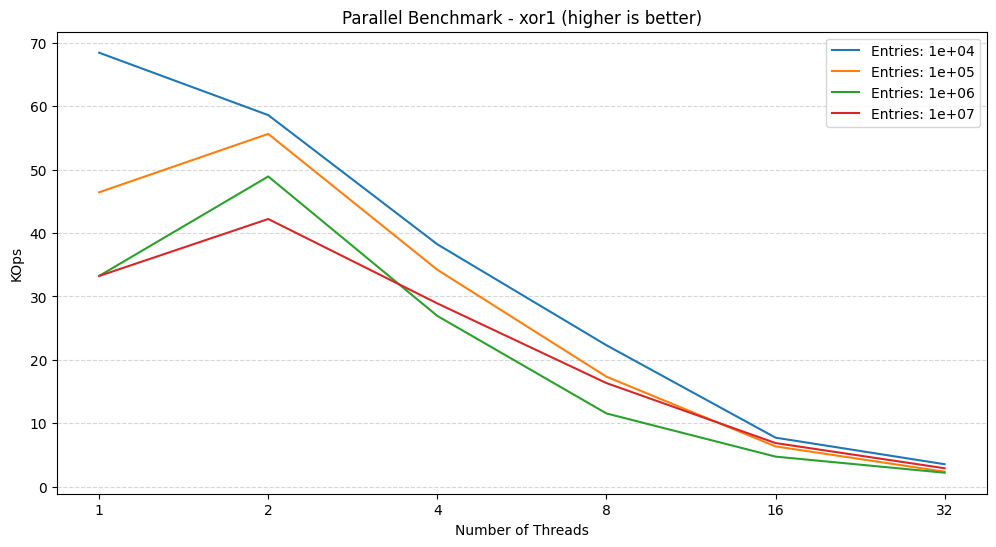

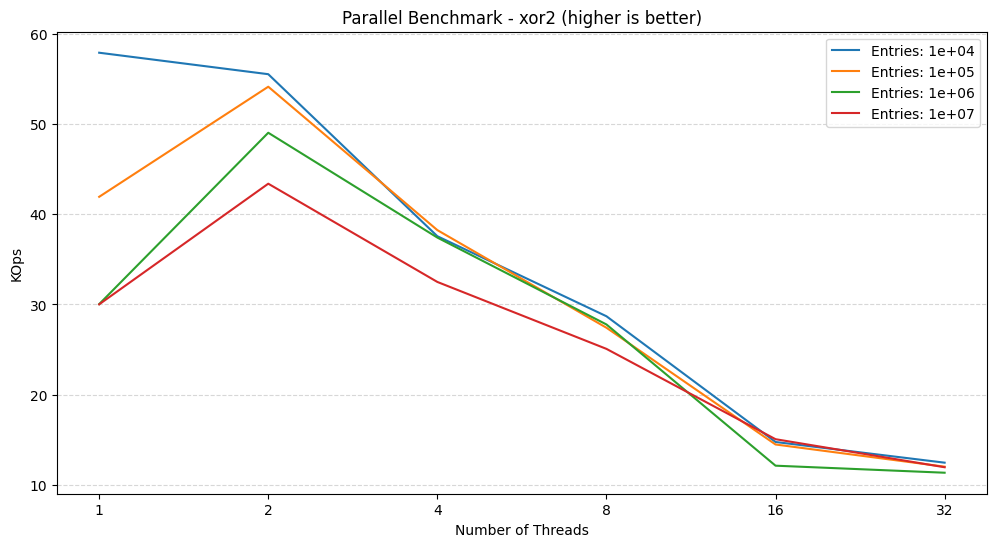

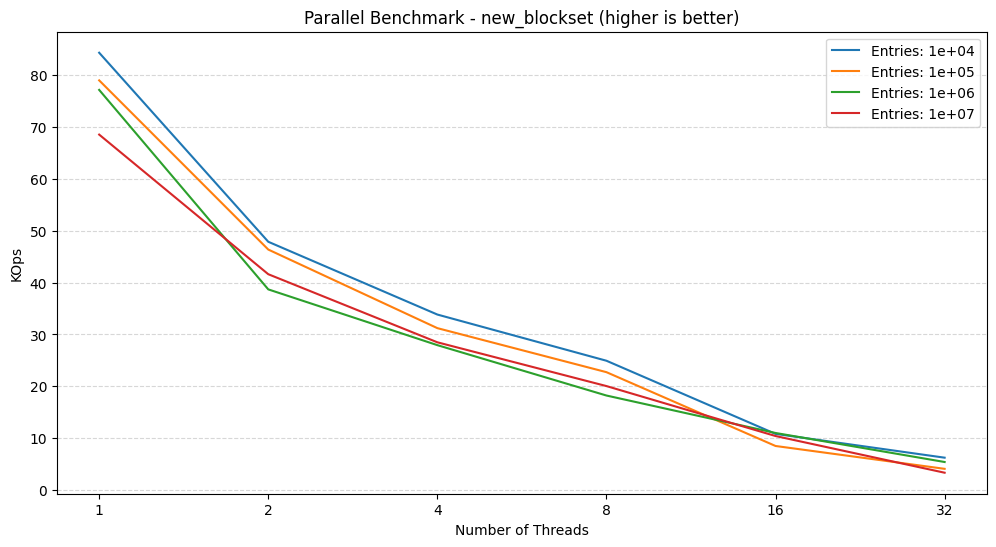

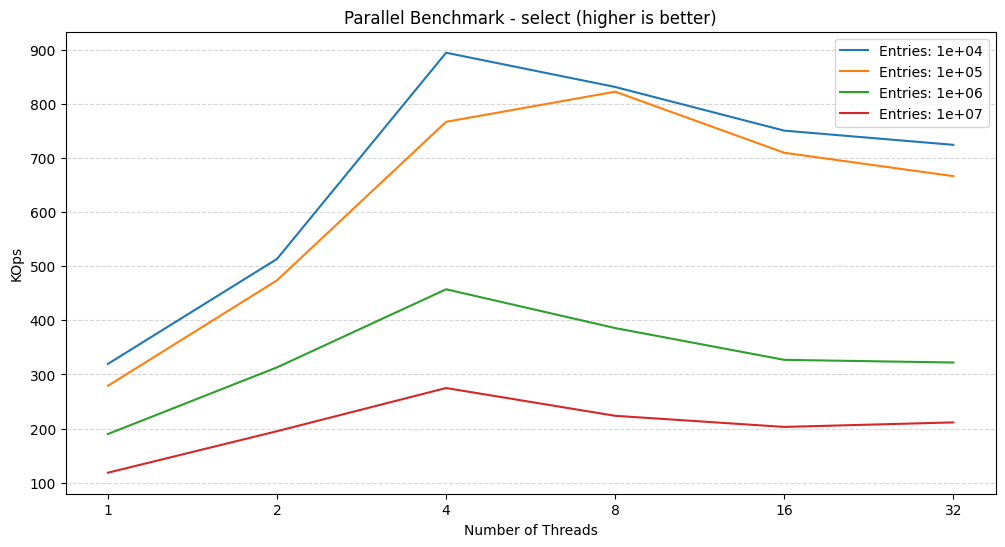

In [ ]:
benchmarks = list([f.removeprefix('parallel_').removesuffix('.csv') for f in reports if f.startswith('parallel')])

# Parallel benchmark
def load_parallel_data():
    result = dict()
    for b in benchmarks:
        result[b] = dict()
        with open(f'{reports_folder}/parallel_{b}.csv', 'r') as f:
            lines = f.readlines()
        column_names = lines[0].strip().split(',')
        e_idx = column_names.index('num_entries')
        t_idx = column_names.index('num_threads')
        k_idx = column_names.index('kop_s')
        for line in lines[1:]:
            values = line.strip().split(',')
            entries = int(values[e_idx])
            threads = int(values[t_idx])
            kops = float(values[k_idx])
            if entries not in result[b]:
                result[b][entries] = dict()
            result[b][entries][threads] = kops

    return result

def plot_parallel():
    for b in benchmarks:
        plt.figure(figsize=(12, 6))
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        for entries, threads_data in values[b].items():
            threads = list(threads_data.keys())
            kops = list(threads_data.values())
            # label should be 1e<value>
            plt.plot(threads, kops, label=f'Entries: {entries:.0e}')

        plt.xlabel('Number of Threads')
        plt.ylabel('KOps')
        plt.title(f'Parallel Benchmark - {b} (higher is better)')
        plt.xscale('log', base=2)
        plt.xticks(threads, labels=threads)
        plt.legend()
        plt.show()

values = load_parallel_data()
plot_parallel()

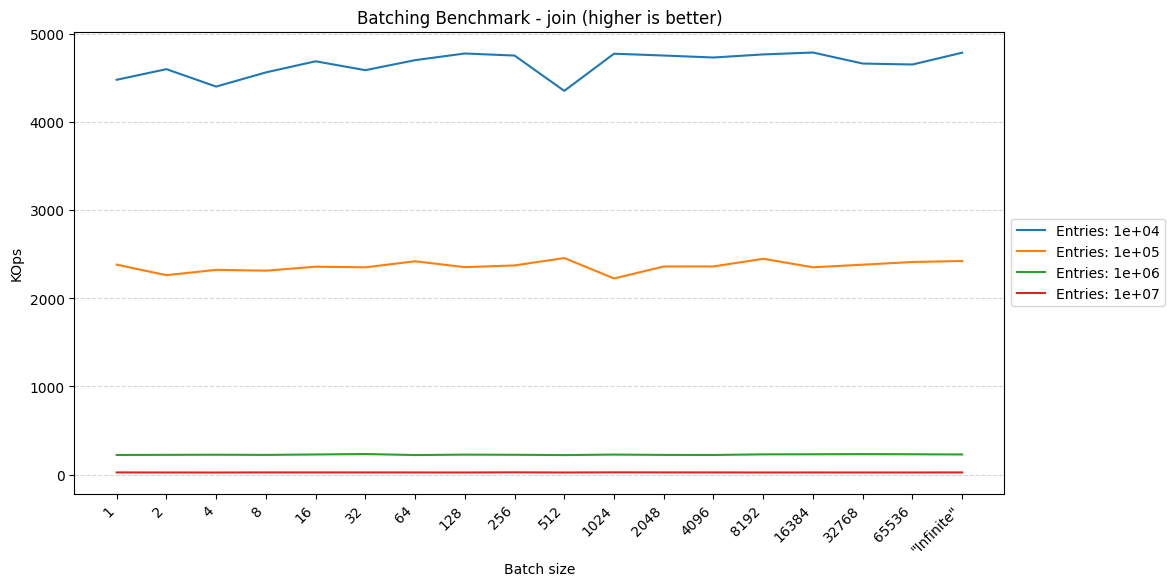

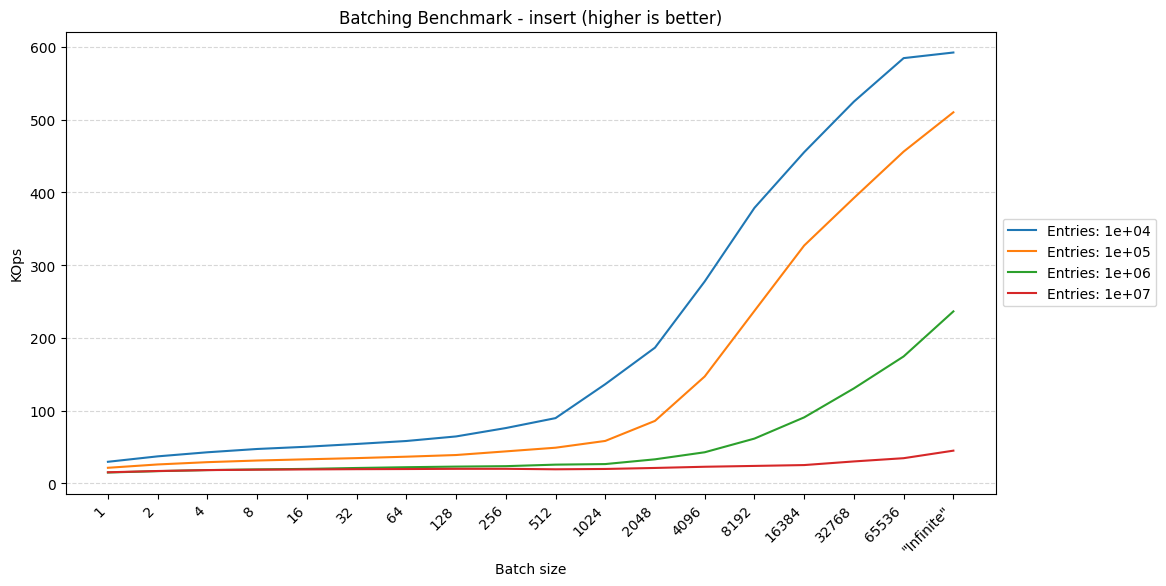

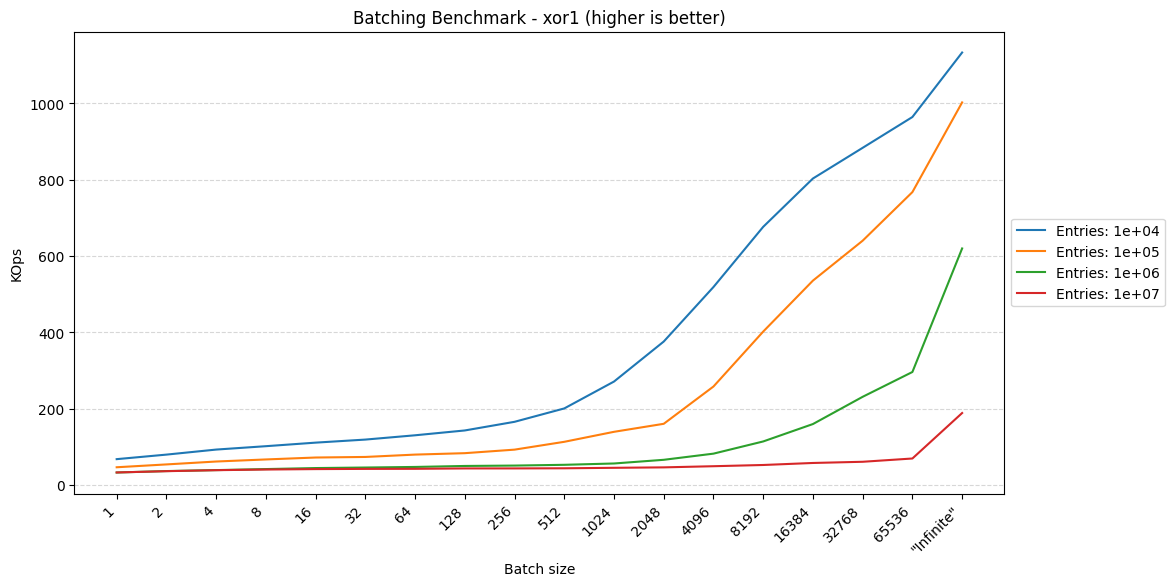

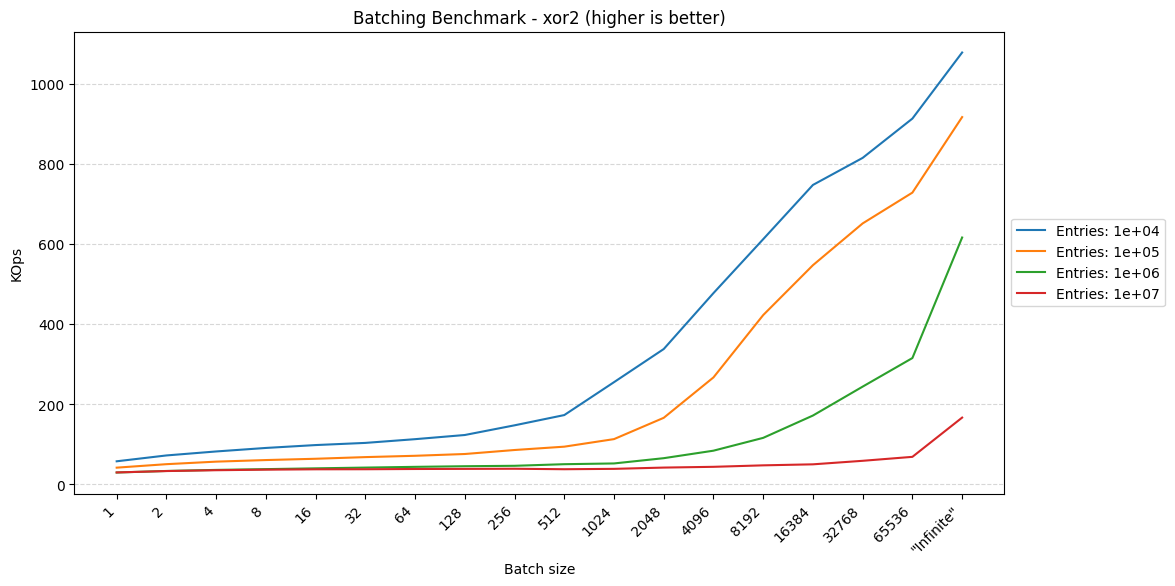

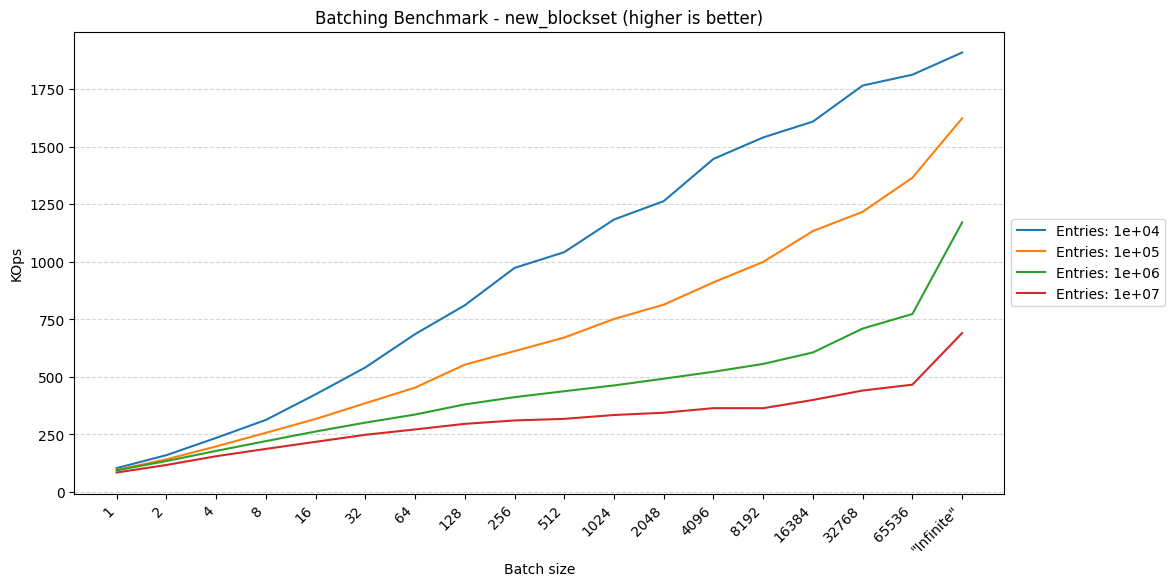

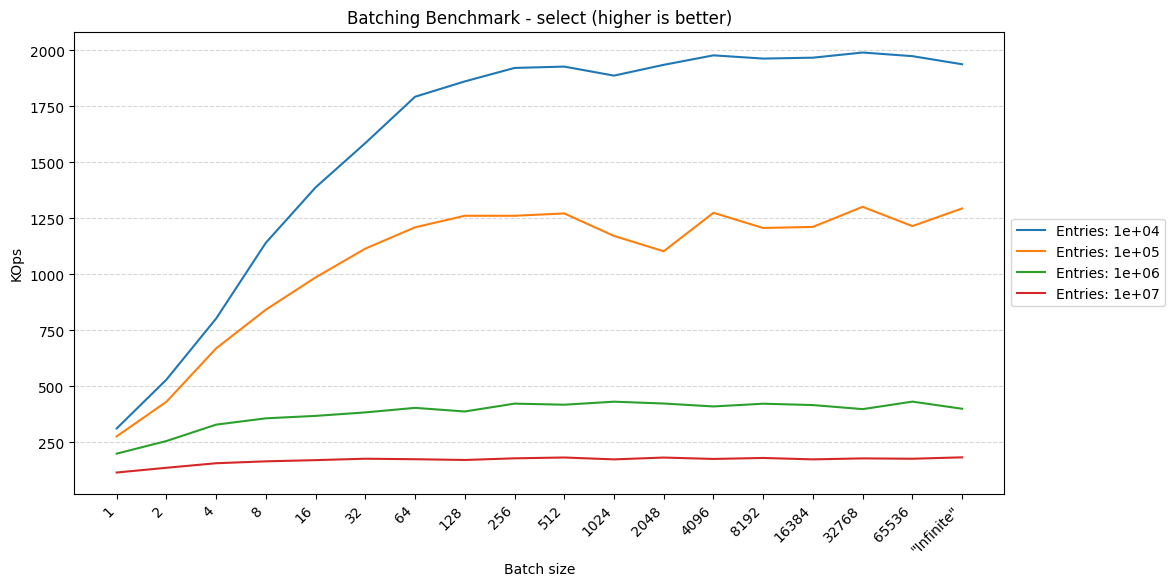

In [ ]:
benchmarks = list([f.removeprefix('batching_').removesuffix('.csv') for f in reports if f.startswith('batching')])

# Batching benchmarks
def load_batching_data():
    result = dict()
    for b in benchmarks:
        result[b] = dict()
        with open(f'{reports_folder}/batching_{b}.csv', 'r') as f:
            lines = f.readlines()
        column_names = lines[0].strip().split(',')
        e_idx = column_names.index('num_entries')
        b_idx = column_names.index('num_batch')
        k_idx = column_names.index('kop_s')
        for line in lines[1:]:
            values = line.strip().split(',')
            entries = int(values[e_idx])
            batch = int(values[b_idx])
            kops = float(values[k_idx])
            if entries not in result[b]:
                result[b][entries] = dict()
            result[b][entries][batch] = kops

    return result

def plot_batching():
    for b in benchmarks:
        plt.figure(figsize=(12, 6))
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        for entries, batch_data in list(values[b].items())[:5]:
            batch = list(batch_data.keys())
            infin = batch.pop(0)
            batch.append(infin)
            kops = list(batch_data.values())
            infin = kops.pop(0)
            kops.append(infin)
            # label should be 1e<value>
            plt.plot(range(len(batch)), kops, label=f'Entries: {entries:.0e}')

        plt.xlabel('Batch size')
        plt.ylabel('KOps')
        plt.title(f'Batching Benchmark - {b} (higher is better)')
        #plt.xscale('symlog', base=2)
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        batch_labels = [str(ba) for ba in batch]
        batch_labels[-1] = '"Infinite"'
        plt.xticks(range(len(batch)), labels=batch_labels, rotation=45, ha='right')
        plt.show()

values = load_batching_data()
plot_batching()

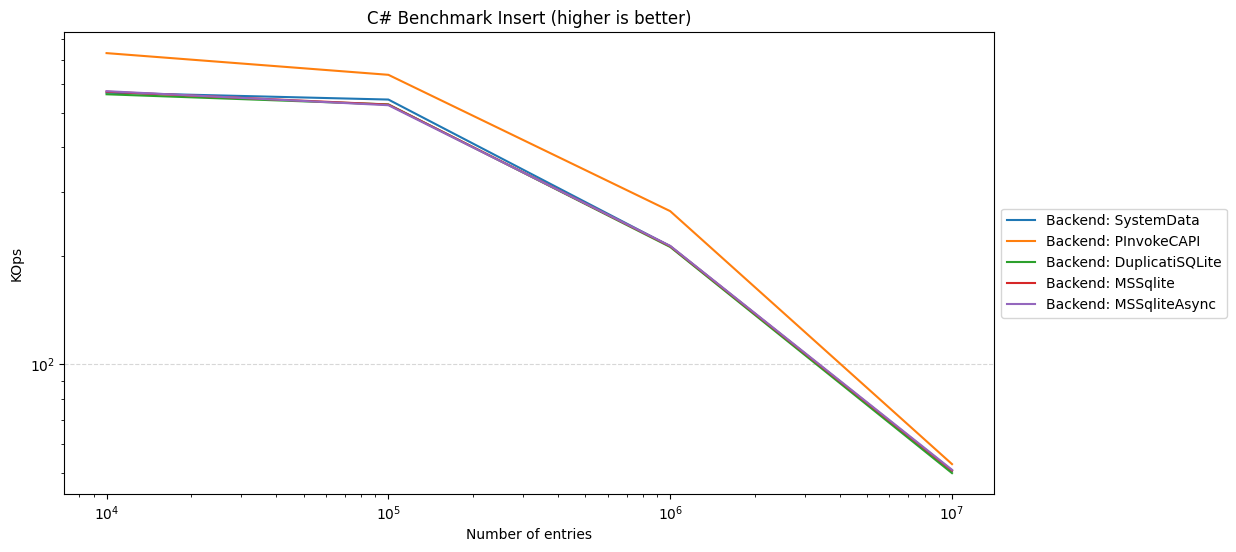

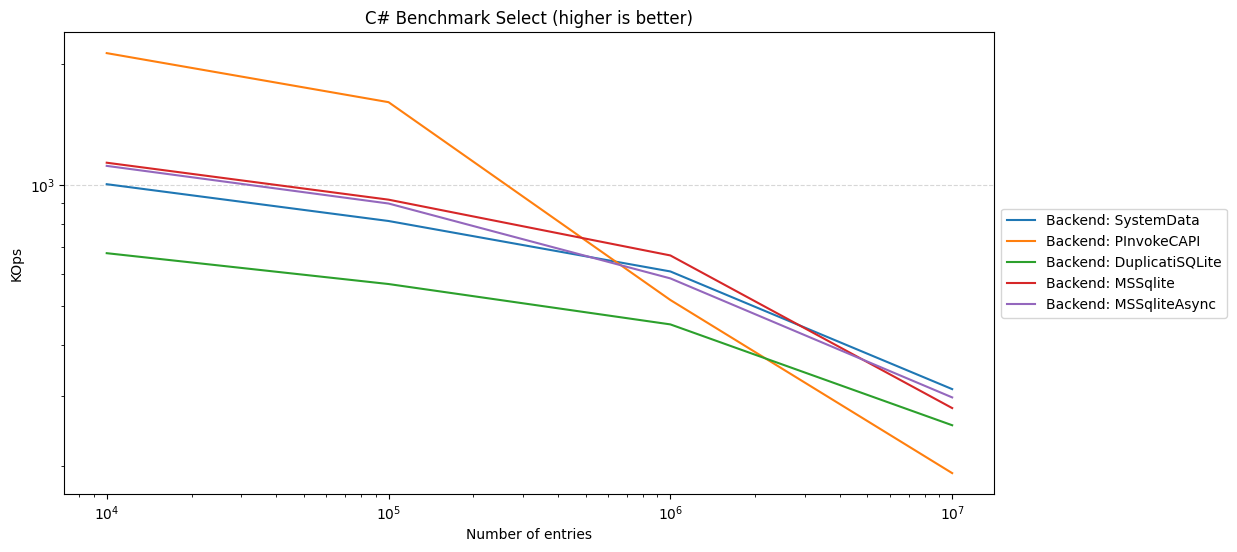

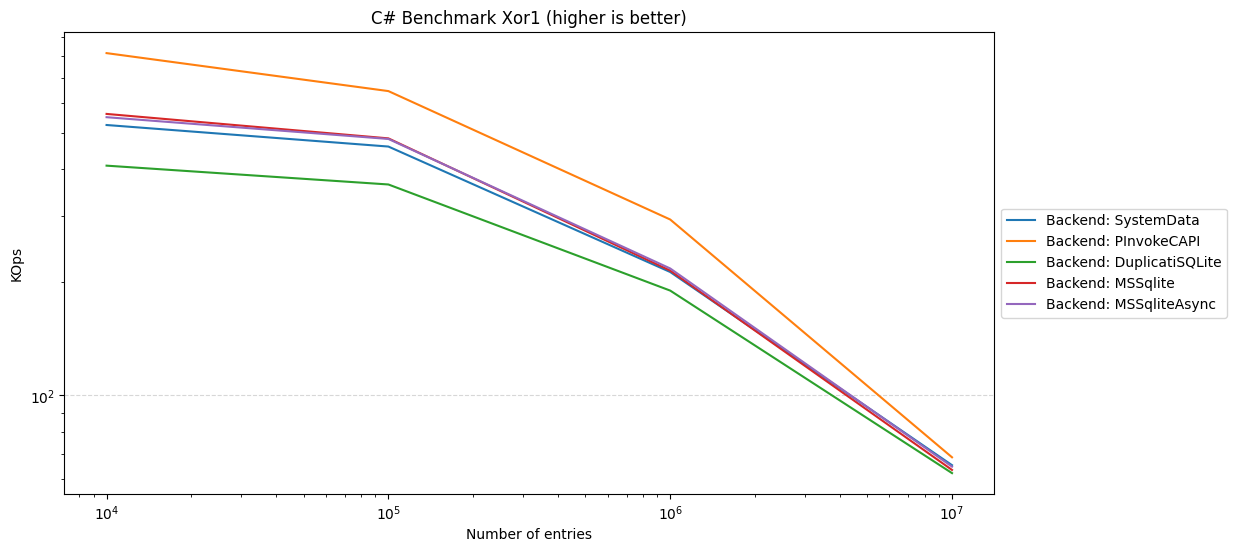

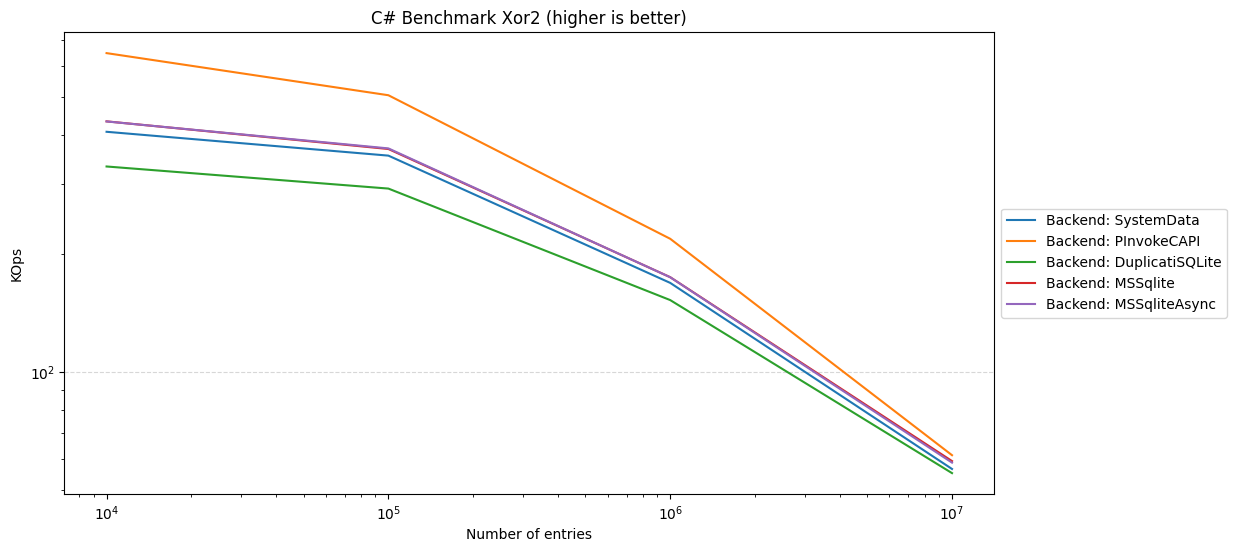

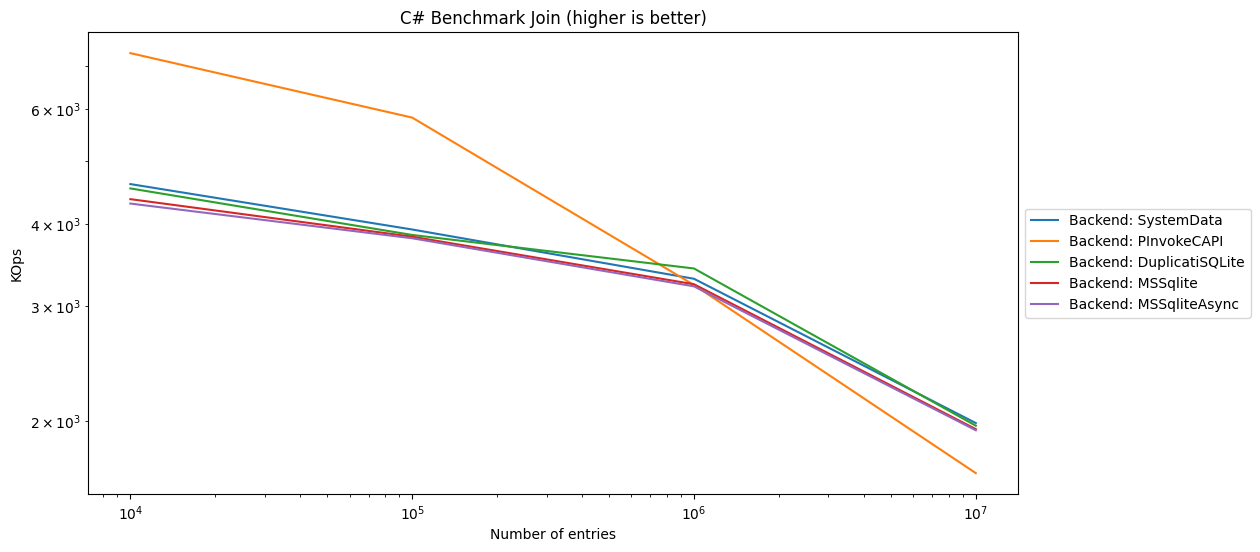

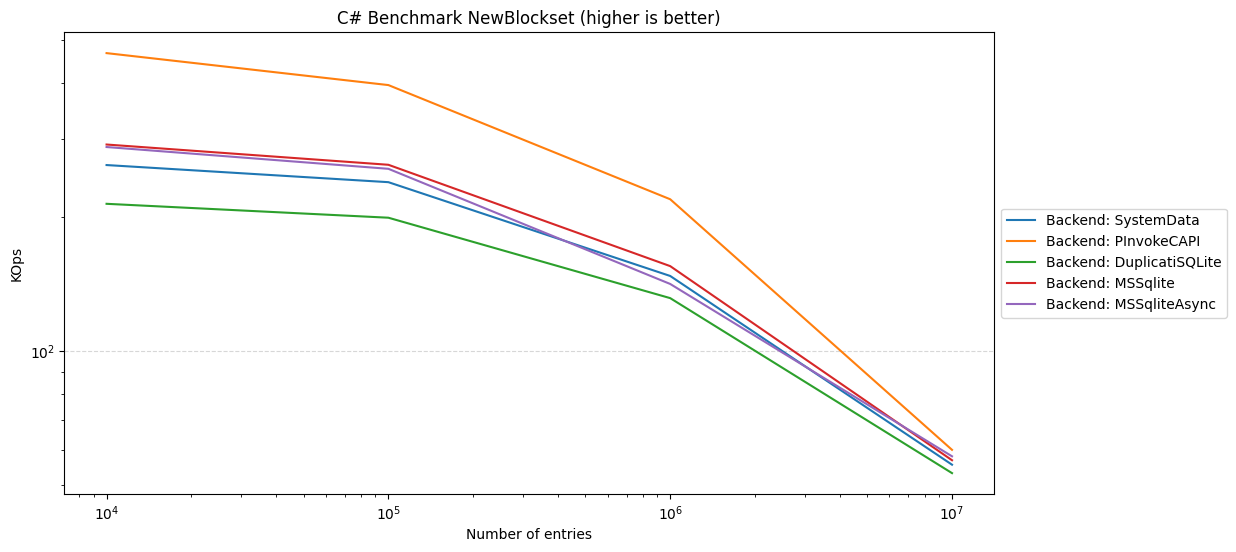

In [ ]:
backends = list([f.removeprefix('sqlite_bench.').removesuffix('-report.csv') for f in reports if f.startswith('sqlite_bench.')])

def parse_cs_report_files():
    result = dict()
    for b in backends:
        with open(f'{reports_folder}/sqlite_bench.{b}-report.csv', 'r') as f:
            lines = f.readlines()
        column_names = lines[0].strip().split(',')
        method_idx = column_names.index('Method')
        e_idx = column_names.index('NumEntries')
        k_idx = column_names.index('K rows/sec (avg)')

        for line in lines[1:]:
            values = next(csv.reader([line.strip()]))
            entries = int(values[e_idx])
            method = values[method_idx]
            kops = float(values[k_idx])
            if method not in result:
                result[method] = dict()
            if b not in result[method]:
                result[method][b] = dict()
            result[method][b][entries] = kops

    return result

values = parse_cs_report_files()
def plot_batching():
    for b in values.keys():
        plt.figure(figsize=(12, 6))
        plt.grid(axis='y', linestyle='--', alpha=0.5)
        for be in backends:
            xs = list(values[b][be].keys())
            ys = list(values[b][be].values())
            plt.plot(xs, ys, label=f'Backend: {be}')

        plt.xlabel('Number of entries')
        plt.ylabel('KOps')
        plt.title(f'C# Benchmark {b} (higher is better)')
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        plt.xscale('log')
        plt.yscale('log')
        plt.show()

plot_batching()
